In [1]:
"""

This Jupyter Notebook implements the following using OPENCV Transformations and Sliding Window Search:

(1) Computes the camera calibration matrix and distortion coefficients given a set of chessboard images.
(2) Applies a distortion correction to raw images.
(3) Uses color transforms, gradients, etc., to create a thresholded binary image.
(4) Applies a perspective transform to rectify binary image ("birds-eye view").
(5) Detects lane pixels and fit to find the lane boundary.
(6) Determines the curvature of the lane and vehicle position with respect to center.
(7) Warps the detected lane boundaries back onto the original image.
(8) Outputs visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

"""
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import math
import os
from collections import deque
from moviepy.editor import VideoFileClip
%matplotlib inline

# Global variables
FIMAGES = glob.glob('./camera_cal/calibration*.jpg')
TESTIMAGES = ['./test_images/' + x for x in os.listdir('./test_images/')]
SRC = np.array([[578, 460], [704, 460], [1070, 686], [240, 686]], dtype=np.float32)
DST = np.array([[280, 0], [1000, 0], [1000, 720], [280, 720]], dtype=np.float32)

In [62]:
def getImages(fnames):
    """
    
    This function imports images from a list of files
    
    Args:
          (1) fnames (str): An array containing the path of the images
    Return:
          (1) images (uint8): An array of all images specified in fnames
          (2) Image Title (str): An array with the names of the image files
    
    """
    images = []
    titles = []
    for file in fnames:
        titles.append(file.split('/')[-1])
        images.append(mpimg.imread(file))
    return images, titles

def display(images, m=20, n=14, k=4, titles=None, axis='off', cmap=None):
    """
    
    This function takes a array of images as an input and displays the images in a window
    
    Args:
            (1) images (uint8): An array of image paths to display
            (2) m, n (int): Dimensions of displays window
            (3) k (int): Number of images per row to display
            (4) titles (str): An array with the plot titles
            (5) axis (str): Plot axis parameter
            (6) cmap (str): Plot colour map
    Returns:   
            (1) A window displaying all images
    
    """
    n_imgs = len(images)
    plt.figure(figsize = (m, n))
    for i,img in enumerate(images):
        plt.subplot(math.ceil(n_imgs/k), k, i+1)
        plt.imshow(img, cmap=cmap)
        if(titles == None):
            plt.title(i)
        else:
            plt.title(titles[i])
        plt.axis(axis)
    plt.show()

def findCorners(image, m=9, n=6):
    """
    
    This function takes an array of images as an input, finds the Chessboard Corners and returns an array of 
    images with the Chessboard corners drawn
    
    Args:
            (1) image (uint8): An 8 bit image
            (2) m, n (int): ChessBoard Dimensions
    Returns:
            (1) dotimage (uint8): Image with the Chessboard corners drawn
            (2) object points (float): List of object points
            (3) image points (float): List of all corner points in the image
            
    """
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....., (6,5,0)
    objp = np.zeros((m*n,3), np.float32)
    objp[:,:2] = np.mgrid[0:m,0:n].T.reshape(-1,2)
    
    # Define empty arrays to store the object points and image points from all images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane
    dotimage = image.copy()
    
    # Step through the images and search for ChessBoard Corners
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
    # Find the ChessBoard Corners
    ret, corners = cv2.findChessboardCorners(gray, (m,n), flags=cv2.CALIB_CB_ADAPTIVE_THRESH)
        
    # If found store the object points and image points
    if(ret == True):
        objpoints.append(objp)
        imgpoints.append(corners)
            
        # Draw the corners
        dotimage = cv2.drawChessboardCorners(dotimage, (m,n), corners, ret)
        
    return dotimage, objpoints, imgpoints
    
def calibrate(img, objp, imgp):
    """
    
    This function returns the calibrated camera matrix, distortion coefficients, rotation, translation vectors
    
    Args:
            (1) img (uint8): An 8-bit image
            (2) objp (float): List of object points
            (3) imgp (float): List of image points
    Returns:
            (1) ret (bool): True if any values returned by the function
            (2) mtx (float): Camera Calibration Matrix
            (3) dist (float): An array of Distortion coefficients
            (4) rvecs (float): Rotation vectors
            (5) tvecs (float): Translation vectors
            
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp, imgp, gray.shape[::-1], None, None) # Calculate corners
    return ret, mtx, dist, rvecs, tvecs

def undistort(img, mtx, dist):
    """
    
    This function undistorts an image given the camera calibration matrix and distortion coefficients
    
    Args:
            (1) img (uint8): An 8-bit distorted image
            (2) mtx (float): Camera calibration Matrix
            (3) dist (float): An array of Distortion coefficients
    Returns:
            (1) dst (uint8): An 8-bit undistorted image
    
    """
    
    return cv2.undistort(img, mtx, dist, None, mtx)

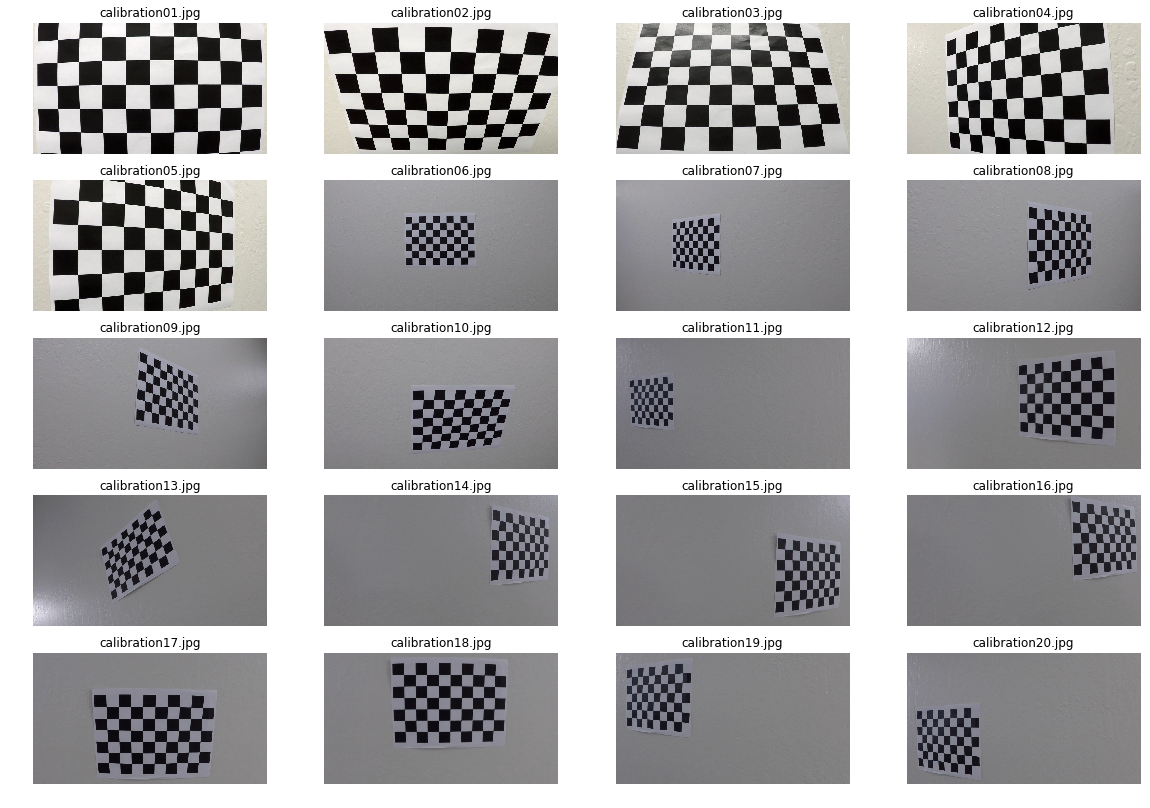

In [3]:
def showChessBoardImages():
    """
    
    This functions loads the chessboard images from the given directory and displays them
    
    Args: None
    Returns: None
    
    """
    chessimg, titles = getImages(FIMAGES)
    display(chessimg, titles=titles)
    
if __name__=="__main__":
    showChessBoardImages()

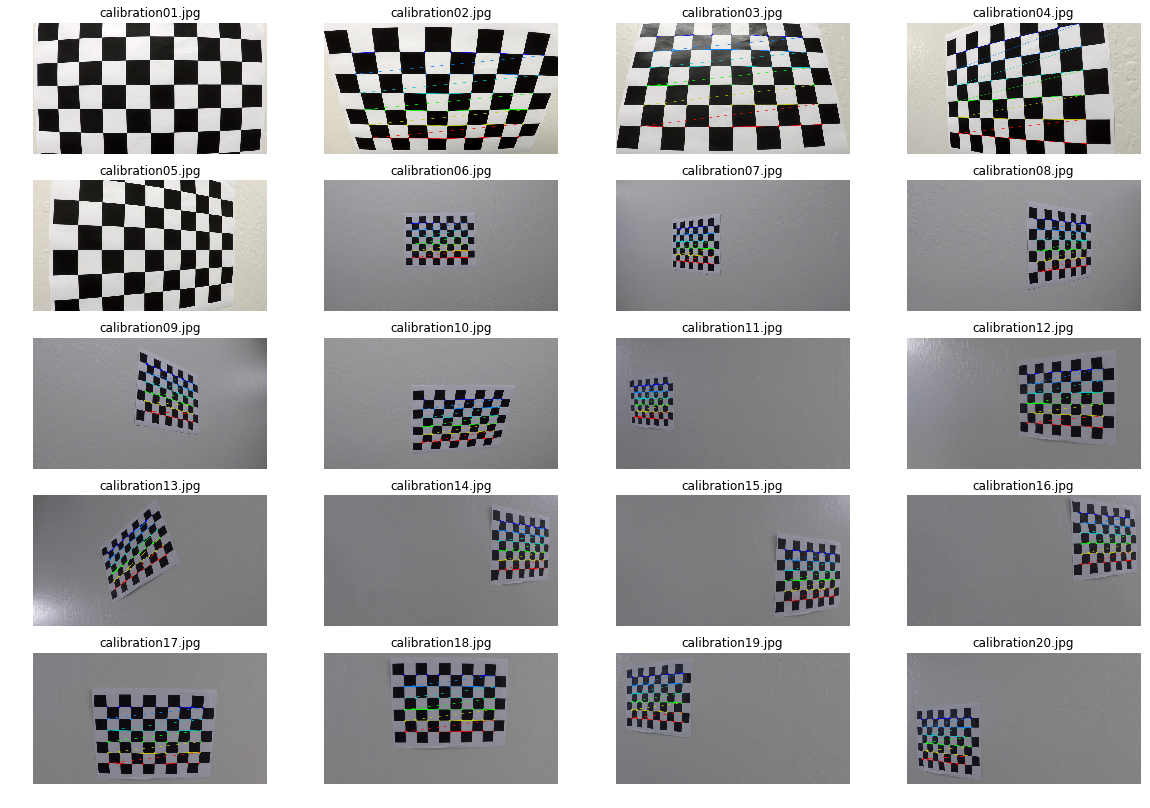

In [4]:
def showChessBoardCorners():
    """
    
    This function loads the chessboard images, gets the image corners and and displays the corners on the images
    
    Args: None
    Returns: None
    
    """
    chessimages, titles = getImages(FIMAGES)
    chessdots = []
    dottitles = []
    objpoints = []
    imagepoints = []
    for i, img in enumerate(chessimages):
        dotimg, objp, imgp = findCorners(img)
        chessdots.append(dotimg)
        objpoints.append(objp)
        imagepoints.append(imgp)
        dottitles.append(titles[i])

    display(chessdots, titles=dottitles)

if __name__=="__main__":
    showChessBoardCorners()

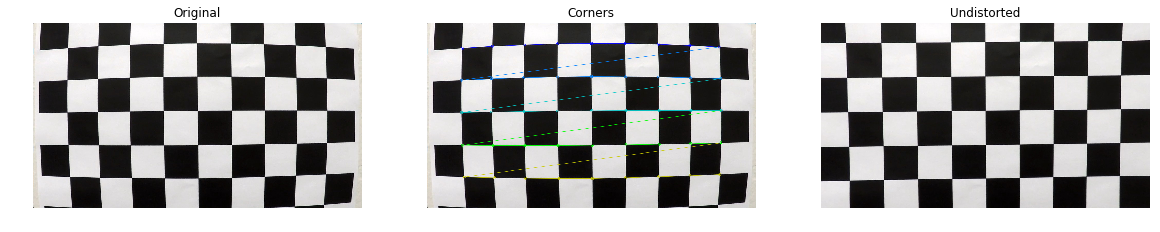

In [5]:
def calibrateCameraDistortion():
    """
    
    This function loads a chessboard image, detects the chessboard corners, gets the camera calibration outputs
    undistorts the image
    
    Args: None
    Returns:
            (1) ret (bool): True if any values returned by the function
            (2) mtx (float): Camera Calibration Matrix
            (3) dist (float): An array of Distortion coefficients
            (4) rvecs (float): Rotation vectors
            (5) tvecs (float): Translation vectors
    
    """
    chessimages, titles = getImages(FIMAGES)
    img = chessimages[0]
    dotimg, objp, imgp = findCorners(img, m=9, n=5)
    ret, mtx, dist, rvecs, tvecs = calibrate(img, objp, imgp) # Calculate calibration matrix and distortion coeff.
    dst = undistort(img, mtx=mtx, dist=dist) # Undistort image
    display([img, dotimg, dst], k=3, titles=['Original', 'Corners', 'Undistorted'])
    return ret, mtx, dist, rvecs, tvecs

if __name__=="__main__":
    RET, MTX, DIST, RVECS, TVECS = calibrateCameraDistortion()

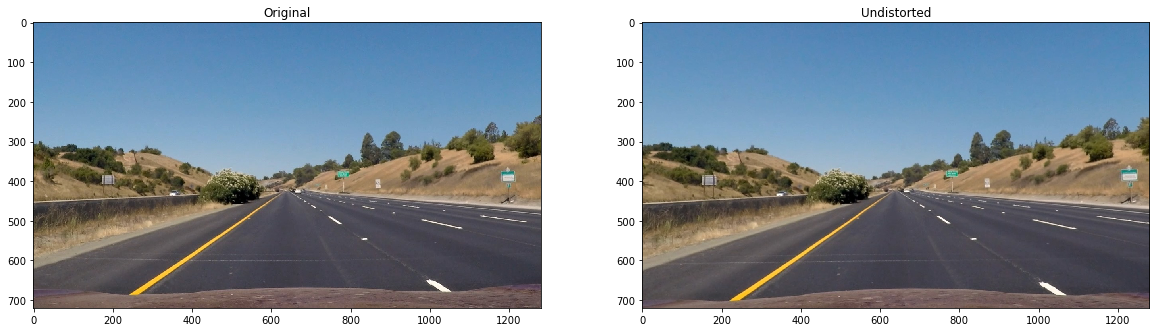

In [6]:
def undistortTestImages():
    """
    
    This function undistorts a test image and displays it
    
    Args: None
    Returns: None
    
    """
    path = TESTIMAGES[0]
    img = mpimg.imread(path)
    dst = undistort(img, mtx=MTX, dist=DIST)
    display([img, dst], k=2, titles=['Original', 'Undistorted'], axis='on')
    
if __name__=="__main__":
    undistortTestImages()

In [7]:
def absGradientThreshold(img, orient='x', k_size=3, grad_thresh=(20,100)):
    """
    
    This function takes an image, calculates the grayscale gradient using the Sobel operator, applies a threshold
    on the gradients and returns a binary image output
    
    Args:
            (1) img (uint8): An 8-bit image
            (2) orient (str): Sobel axis for gradient calculations
            (3) k_size (int): Sobel kernel size
            (4) grad_thresh (float): A tuple with low and high threshold values for the individual gradients
    Returns:
            (1) binary_output (binary): A binary image output after applying the Sobel operator and gradient
                thresholds on the input image
    
    """
    
    assert(orient == 'x' or orient == 'y' or orient == 'xy'), "Invalid Orientation: Choose 'x', 'y' or 'xy'"
    
    # Convert to grayscale and apply the sobel operator
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=k_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=k_size)
    
    # Calculate absolute gradient values
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Rescale gradient values to uint8
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    sxbinary = np.zeros_like(scaled_sobelx)
    sybinary = np.zeros_like(scaled_sobely)
    
    #Apply gradient thresholds
    sxbinary[(scaled_sobelx > grad_thresh[0]) & (scaled_sobelx <= grad_thresh[1])] = 1
    sybinary[(scaled_sobely > grad_thresh[0]) & (scaled_sobely <= grad_thresh[1])] = 1
    
    if(orient == 'x'):
        binary_output = sxbinary
    elif(orient == 'y'):
        binary_output = sybinary
    elif(orient == 'xy'):
        binary_output = sxbinary | sybinary
    else:
        raise ValueError("Invalid Orientation: Choose 'x', 'y' or 'xy'")
        
    return binary_output

def absMagnitudeThreshold(img, k_size=3, mag_thresh=(20,100)):
    """
    
    This function takes an image, calculates the grayscale gradient using the Sobel operator, applies a threshold
    based on the gradient magnitudes and returns a binary image output
    
    Args:
            (1) img (uint8): An 8-bit image
            (2) k_size (int): Sobel kernel size
            (3) mag_thresh (float): A tuple with low and high threshold values for the gradient magnitudes
    Returns:
            (1) binary_output (binary): A binary image output after applying the Sobel operator and magnitude
                thresholds on the input image
    
    """
    # Convert to grayscale and apply the sobel operator
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=k_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=k_size)
    
    # Calculate the gradient magnitudes
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    
    # Calculate the absolute values of gradient magnitudes
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Rescale the gradient magnitudes to uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    
    # Apply the magnitude thresholds
    magbinary = np.zeros_like(scaled_sobel)
    magbinary[(scaled_sobel > mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    binary_output = magbinary
    
    return binary_output

def absDirectionThreshold(img, k_size=3, dir_thresh=(0,np.pi/2)):
    """
    
    This function takes an image, calculates the grayscale gradient using the Sobel operator, applies a threshold
    based on the gradient vector direction and returns a binary image output
    
    Args:
            (1) img (uint8): An 8-bit image
            (2) k_size (int): Sobel kernel size
            (3) dir_thresh (float): A tuple with low and high threshold values for the gradient directions
    Returns:
            (1) binary_output (binary): A binary image output after applying the Sobel operator and direction
                thresholds on the input image
    
    """
    # Convert to grayscale and apply the sobel operator
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=k_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=k_size)
    
    # Calculate the absolute values of the gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Calculate the gradient directions
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    
    # Apply the direction thresholds
    dirbinary = np.zeros_like(dir_sobel)
    dirbinary[(dir_sobel > dir_thresh[0]) & (dir_sobel <= dir_thresh[1])] = 1
    
    binary_output = dirbinary
    
    return binary_output

def combinedGradientThreshold(img, k_size=3, grad_thresh=(50,150), mag_thresh=(50,150), dir_thresh=(0.7,1.3)):
    """
    
    This function takes an image, calculates the grayscale gradient using the Sobel operator, applies a combined
    threshold based on the gradients, magnitude and direction and returns a binary image output
    
    Args:
            (1) img (uint8): An 8-bit image
            (2) k_size (int): Sobel kernel size
            (3) grad_thresh (float): A tuple with low and high threshold values for the individual gradients
            (4) mag_thresh (float): A tuple with low and high threshold values for the gradient magnitudes
            (5) dir_thresh (float): A tuple with low and high threshold values for the gradient directions
    Returns:
            (1) combined (binary): A binary image output after applying the Sobel operator and combined
                thresholds on the input image
    
    """
    # Calculate binary images from each gradient, magnitude and direction thresholds
    gradx = absGradientThreshold(img, orient='x', k_size=k_size, grad_thresh=grad_thresh)
    mag_binary = absMagnitudeThreshold(img, k_size=k_size, mag_thresh=mag_thresh)
    dir_binary = absDirectionThreshold(img, k_size=k_size, dir_thresh=dir_thresh)
    
    # Apply a combined threshold
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

def colorThreshold(img, s_thresh=(127,255), h_thresh=(0,35), l_thresh=65):
    """
    
    This function takes an image, converts the image to hls color space, applies a threshold based on the 
    hue, lightness and saturation values and returns a binary image output
    
    Args:
            (1) img (uint8): An 8-bit image
            (2) s_thresh (float): A tuple with low and high threshold values for the s channel
            (3) h_thresh (float): A tuple with low and high threshold values for the h channel
            (4) l_thresh (float): A tuple with low threshold value for the l channel
    Returns:
            (1) s_binary (binary): A binary image output after applying the Sobel operator and color
                thresholds on the input image
    
    """
    # Convert the RGB image to HLS and split into individual channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Apply color thresholds
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1]) & (h_channel > h_thresh[0]) & \
            (h_channel < h_thresh[1]) & (l_channel > l_thresh)] = 1
    
    return s_binary

def combinedColorGradientThreshold(img, orient='x', k_size=3, s_thresh=(90,255), grad_thresh=(50,150)):
    """
    
    This function takes an image, applies a combined threshold based on the gradient values, color spaces values
    and returns a binary image output and a 3 channel output
    
    Args:
            (1) img (uint8): An 8-bit image
            (2) orient (str): Sobel axis for gradient calculations
            (3) k_size (int): Sobel kernel size
            (4) s_thresh (float): A tuple with low and high threshold values for the s channel
            (5) grad_thresh (float): A tuple with low and high threshold values for the individual gradients
    Returns:
            (1) combined_binary (binary): A binary image output after applying the Sobel operator and combined
                thresholds on the input image
            (2) color_binary (uint8): A 3 channel output with each channel displaying the contribution of each
                threshold
    
    """
    # Calculate the color and gradient binary images
    s_binary = colorThreshold(img, s_thresh=s_thresh)
    sxbinary = absGradientThreshold(img, orient=orient, k_size=k_size, grad_thresh=grad_thresh)
    scombined = combinedGradientThreshold(img, k_size=k_size, grad_thresh=grad_thresh)
    
    # Stack the gradient and color binaries
    color_binary = (np.dstack((scombined, sxbinary, s_binary)) * 255.999).astype(np.uint8)
    
    # Apply a combined threshold
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1) | (scombined == 1)] = 1
    
    return combined_binary, color_binary

def perspectiveTransform(img, src, dst):
    """
    
    This function calculates the perspective transform matrix and transforms the image based on source and 
    destination points
    
    Args:
            (1) img (uint8): An 8-bit image
            (2) src (float): An array of source points
            (3) dst (float): An array of destination points
    Returns:
            (1) warped (uint8): A perspective transformed image
            (2) M (float): Perspective transformation matrix
            
    """
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst) # Calculate transformation matrix 
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR) # Transform the image
    return warped, M

def drawPolyLines(img, points, imgtype = 'rgb'):
    """
    
    This function takes and image and draws a polygon on the image
    
    Args:
            (1) img (uint8 or binary): An image input
            (2) points (float): An array of polygon vertices
    Returns:
            (1) img (uint8): An image with polygon plotted
    
    """
    points = np.array(points, np.int32)
    points = points.reshape((-1,1,2))
    
    if(imgtype == 'binary'):
        img = (np.dstack((img, img, img)) * 255.999).astype(np.uint8)
        
    img = cv2.polylines(img,[points],True,(255,0,0), 2)
    return img

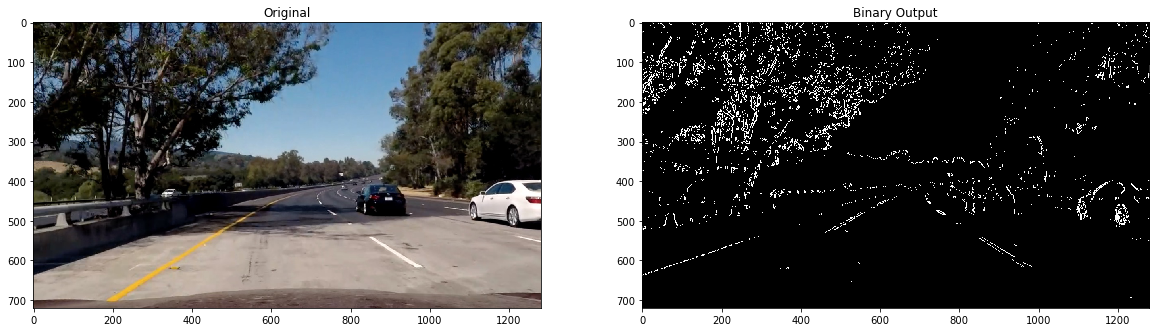

In [8]:
def showGradientBinaryOutput():
    """
    
    This function displays the original and thresholded image using the combined gradient thresholds
    
    Args: None
    Returns: None
    
    """
    path = TESTIMAGES[6]
    img = mpimg.imread(path)
    img = undistort(img, mtx=MTX, dist=DIST)
    binary_output = combinedGradientThreshold(img, grad_thresh=(50, 150), mag_thresh=(50, 150), \
                                              dir_thresh=(0.7, 1.3))
    display([img, binary_output], k=2, titles=['Original', 'Binary Output'], axis='on', cmap='gray')

if __name__=="__main__":
    showGradientBinaryOutput()

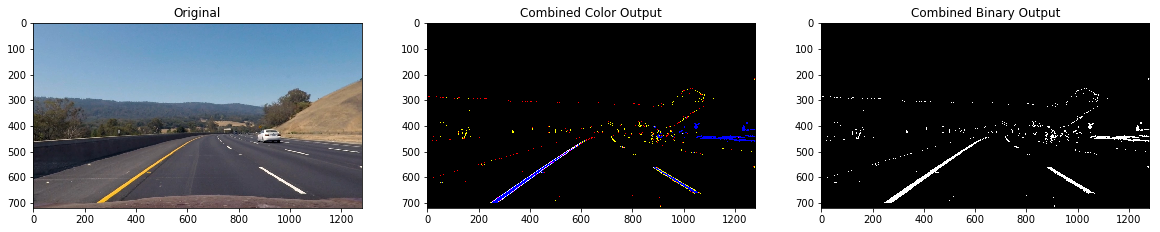

In [9]:
def showColorGradientBinary():
    """
    
    This function displays the original and the combined thresholded image of the gradient and color thresholds
    
    Args: None
    Returns: None
    
    """
    path = TESTIMAGES[4]
    img = mpimg.imread(path)
    img = undistort(img, mtx=MTX, dist=DIST)
    combined, color = combinedColorGradientThreshold(img, s_thresh=(90,255), grad_thresh=(50,150))
    display([img, color, combined], k=3, titles=['Original','Combined Color Output', 'Combined Binary Output'], \
            axis='on', cmap = 'gray')
    return combined

if __name__=="__main__":
    showColorGradientBinary()

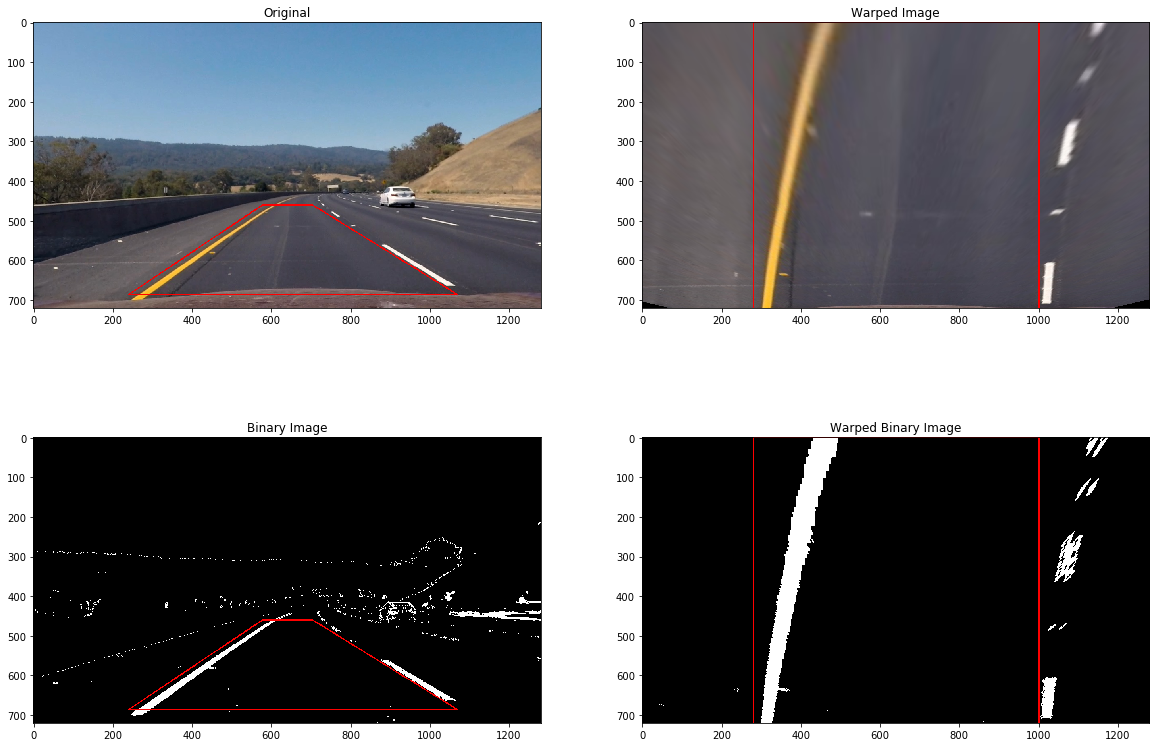

In [10]:
def showPerspectiveTransform():
    """
    
    This function displays the original image, the binary image and their perspective transforms with the source
    and destination points plotted
    
    Args: None
    Returns: None
    
    """
    path = TESTIMAGES[4]
    img = mpimg.imread(path)
    img = undistort(img, mtx=MTX, dist=DIST)
    combined_binary, _ = combinedColorGradientThreshold(img)
    warped_image, M_image = perspectiveTransform(img, SRC, DST)
    warped_binary, M_binary = perspectiveTransform(combined_binary, SRC, DST)
    img = drawPolyLines(img, SRC)
    warped_image = drawPolyLines(warped_image, DST)
    combined_binary = drawPolyLines(combined_binary, SRC, imgtype='binary')
    warped_binary = drawPolyLines(warped_binary, DST, imgtype='binary')
    display([img, warped_image, combined_binary, warped_binary], k=2, \
            titles=['Original', 'Warped Image', 'Binary Image', 'Warped Binary Image' ], axis='on', cmap='gray')
                                                                                
if __name__=="__main__":
    showPerspectiveTransform()

In [11]:
class Line():
    """
    
    This class defines a line object
    
    """
    def __init__(self):
        """
        
        This function initializes the default object attributes
        
        """
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen=5) 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the last 5 recent fits
        self.recent_fit = deque(maxlen=5)  
        #radius of curvature of the line in some units
        self.radius = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = []
        #y values for detected line pixels
        self.ally = []
        #Store number of images
        self.nimages = 0
        
    def getLanePositions(self, binary_warped):
        """
        
        This object attribute calculates the midpoint and base point of the line objects
        
        Args:
                (1) binary_warped (binary): A binary warped image
        Returns:
                (1) midpoint (int): The midpoint of the binary image along a particular axis
                (2) x_base (int): The histogram peak location
                
        """
        
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        if (self == left):
            x_base = np.argmax(histogram[:midpoint])
        elif (self == right):
            x_base = np.argmax(histogram[midpoint:]) + midpoint
        
        return midpoint, x_base
    
    def blindSearch(self, binary_warped, nwindows, margin, minpix, x_current, nonzerox, nonzeroy, window_height, \
                   out, filetype):
        """
        
        This function performs a blind search on the binary image using sliding window search and returns the 
        lane pixel positions
        
        Args:
                (1) binary_warped (binary): A binary warped image
                (2) nwindows (int): Maximum number of windows
                (3) margin (int): Maximum pixels to search on either side of the window center along the x axis
                (4) minpix (int): Minimum number of pixels to recenter window
                (5) x_current (int): X co-ordinate of window center
                (6) nonzerox (int): x coordinates of nonzero pixels in the binary image
                (7) nonzeroy (int): y coordinates of nonzero pixels in the binary image
                (8) window_height (int): height of each window in pixels
                (9) out (uint8): 3 channel image to draw the windows
               (10) filetype (str): Type of file processed
        Returns:
                (1) lane_inds (int): An array of lane positions
                (2) out (uint8): Binary image with windows drawn
        
        """
        
        lane_inds = []
        
        for window in range(nwindows):
        
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin
            
            if (filetype == 'image'):
                # Draw the windows on the visualization image
                out = cv2.rectangle(out,(win_x_low,win_y_low),(win_x_high,win_y_high),(0,255,0), 5) 
            
            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_low) & \
                              (nonzerox < win_x_high)).nonzero()[0]
            
            # Append these indices to the lists
            lane_inds.append(good_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:
                x_current = np.int(np.mean(nonzerox[good_inds]))
        
        # Concatenate the arrays of indices
        lane_inds = np.concatenate(lane_inds)
        
        return lane_inds, out
    
    def knownSearch(self, binary_warped, margin, nonzerox, nonzeroy, fit, nwindows, minpix, x_current,\
                    window_height, out, filetype):
        """
        
        This function performs a search on the binary image if the fit of the lanes is known from the
        previous image and returns the lane pixel positions
        
        Args:
                (1) binary_warped (binary): A binary warped image
                (2) margin (int): Maximum pixels to search on either side of the window center along the x axis
                (3) nonzerox (int): x coordinates of nonzero pixels in the binary image
                (4) nonzeroy (int): y coordinates of nonzero pixels in the binary image
                (5) fit (float): An array of fit coefficients from the previous image
                (6) nwindows (int): Maximum number of windows
                (7) minpix (int): Minimum number of pixels to recenter window
                (8) x_current (int): X co-ordinate of window center
                (9) window_height (int): height of each window in pixels
               (10) out (uint8): 3 channel image to draw the windows
               (11) filetype (str): Type of file processed
        Returns:
                (1) lane_inds (int): An array of lane positions
                (2) out (uint8): Binary image with windows drawn
        
        """
        
        lane_inds = []
        
        lane_inds = ((nonzerox > (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] - margin)) & \
                          (nonzerox < (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] + margin))) 
        
        return lane_inds, out
    
    def findLanes(self, binary_warped, filetype, nwindows, margin, minpix):
        """
        
        This function finds the lane pixel locations, fits a second order polynomial and returns the fit
        coeffecients and x, y locations of the lane pixels
        
        Args:
                (1) binary_warped (binary): A binary warped image
                (2) filetype (str): Type of file processed
                (3) nwindows (int): Maximum number of windows
                (4) margin (int): Maximum pixels to search on either side of the window center along the x axis
                (5) minpix (int): Minimum number of pixels to recenter window
               
        Returns:
                (1) fit (float): The coeffients of the fit polynomial on the lane pixels
                (2) x, y (int): The x, y coordinates of the lane pixels
                (3) out_img (uint8): An 8bit image with windows drawn on it
        
        """
        
        mid, xbase = self.getLanePositions(binary_warped)
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Current positions to be updated for each window
        x_current = xbase
        
        if (self.detected == False):
            lane_inds, out_img = self.blindSearch(binary_warped, nwindows, margin, minpix, x_current, nonzerox, \
                                                  nonzeroy, window_height, out=out_img, filetype=filetype)
                                                              
        elif (self.detected == True):
            fit = self.best_fit
            lane_inds, out_img = self.knownSearch(binary_warped, margin, nonzerox, nonzeroy, fit, nwindows, margin, \
                                        x_current, window_height, out=out_img, filetype=filetype)
        
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 
        
        fit = np.polyfit(y, x, 2)
        
        return fit, x, y, out_img
            

In [25]:
"""
def radius(x, y):
    ymperpixels = 10./720 # meters per pixel in y dimension
    xmperpixels = 3.0/700 # meteres per pixel in x dimension
    fitm = np.polyfit(y*ymperpixels, x*xmperpixels, 2)
    radius = ((1 + (2*fitm[0]*np.max(y) + fitm[1])**2)**1.5) / np.absolute(2*fitm[0])
    return radius
"""

def radius2(left_bottom, right_bottom):
    """
    
    This function calculates the radius of curvature of the lane lines
    
    Args:
            (1) left_bottom (int): The x co-ordinate of the left lane lower intercept
            (2) right_bottom (int): The x co-ordinate of the right lane lower intercept
    Returns:
            (1) left_curverad (float): Left lane radius of curvature 
            (2) right_curverad (float): Right lane radius of curvature
    
    """
    
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 5e-4
    
    leftx = np.array([left_bottom + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
    rightx = np.array([right_bottom + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def sanityCheck(leftr, rightr):
    
    """
    
    This function compares the left lane radius, the right lane radius and checks if its within bounds
    
    Args:
            (1) leftr (float): Left lane radius of curvature
            (2) rightr (float): Right lane radius of curvature
    Returns:
            (1) sanity (bool): True if the radius of curvatures are within bounds
            
    """
    diff = abs(leftr - rightr)
    sanity = False
    x = np.array([0, 600], np.float64)
    #import pdb; pdb.set_trace()
    if (diff >= x[0] and diff < x[1]):
        sanity = True
    #import pdb; pdb.set_trace()
    return sanity

def intercepts(fit):
    """
    
    This function calculates the x intercepts with the image boundaries
    
    Args:
            (1) fit (float): An array of polynomial fit coefficients
    Returns:
            (1) top (int): Top intercept
            (2) bottom (int): Bottom intercept
    
    """
            
    bottom = fit[0]*720**2 + fit[1]*720 + fit[2]
    top = fit[2]
    return top, bottom

def vehiclePosition(leftint, rightint):
    """
    
    This function calculates the position of the vehicle with respect to the center
    
    Args:
            (1) leftint (float): The bottom intercept of the left lane
            (2) rightint (float): The bottom intercept of the right lane
    Returns:
            (1) position (float): The position of the camera from the image origin in meters
            (2) deviation (float): The position of the vehicle with respect to the center of the lane lines
    
    """
    position = (leftint + rightint) / 2
    deviation = abs((640 - position)*3.0/600) 
    
    return position, deviation

In [35]:
def processImage(img, nwindows=9, minpix=50, margin=100, filetype='video'):
    
    """
    
    -> This function calls the undistort, combinedColorGradientThreshold, perspectiveTransform to transforms the image,
       findLanes function to find the lane pixels, radius2 function to calculate the radius of curvature, 
       vehiclePosition function to calculate the vehicle position in the lanes and the sanityCheck function to check
       if the lane lines make sense. 
    -> It updates the object attributes with the correct values and returns the images 
       with lane lines plotted.
    
    Args:
            (1) img (uint8): An 8bit image
            (2) nwindows (int): Maximum number of windows
            (3) minpix (int): Minimum number of pixels to recenter window
            (4) margin (int): Maximum pixels to search on either side of the window center along the x axis
            (5) filetype (str): Type of file processed
    Returns:
            if filetype == 'video'
            (1) result (unit8): An image with lane lines drawn
            if filetype == 'image'
            (1) result (uint8): An image with fit polynomial and lane pixels highlighted
            (2) img (uint8): Undistorted Image
            (3) left_fitx (float): An array with all polynomial points of the left lane
            (4) right_fitx (float): An array with all polynomial points of the right lane
            (5) ploty (float): An array of uniform y axis points
    
    """
    
    # Transform the image
    img = undistort(img, mtx=MTX, dist=DIST)
    combined_binary, _ = combinedColorGradientThreshold(img)
    image_warped, M_image = perspectiveTransform(img, SRC, DST)
    binary_warped, M_binary = perspectiveTransform(combined_binary, SRC, DST)
    
    # Calculate the lane pixels and the polynomial fit
    left_fit, leftx, lefty, leftout = left.findLanes(binary_warped,filetype, nwindows, margin, minpix)
    right_fit, rightx, righty, rightout = right.findLanes(binary_warped, filetype, nwindows, margin, \
                                                          minpix)
    
    #Calculate the lane intercepts
    lefttop, leftbottom = intercepts(left_fit)
    righttop, rightbottom = intercepts(right_fit)
    
    # Calculate the lane radius of curvature
    leftradius, rightradius = radius2(leftbottom, rightbottom)
    
    # Calculate the vehicle position and deviation from the center
    pos, deviation = vehiclePosition(leftbottom, rightbottom)
    
    # Distance from left and write lanes
    leftdist = pos - leftbottom
    rightdist = rightbottom - pos
    
    #Perform the sanity check
    sanity = sanityCheck(leftradius, rightradius)
    
    count = 0
    
    # Update the object attributes
    if(sanity == True):
        
        left.recent_xfitted.append(leftx)
        right.recent_xfitted.append(rightx)
        
        left.allx.append(leftx)
        left.ally.append(lefty)
        right.allx.append(rightx)
        right.ally.append(righty)
        
        left.bestx = np.mean(np.concatenate(left.recent_xfitted))
        right.bestx = np.mean(np.concatenate(right.recent_xfitted))
        
        if (left.nimages == 0 & right.nimages == 0):
            left.diffs = np.subtract(left_fit, [0,0,0])
            right.diffs = np.subtract(right_fit, [0,0,0])
        else:
            left.diffs = np.subtract(left_fit, left.recent_fit[-1])
            right.diffs = np.subtract(right_fit, right.recent_fit[-1])
        
        left.recent_fit.append(left_fit)
        right.recent_fit.append(right_fit)
        
        left.best_fit = np.mean(left.recent_fit, axis=0)
        right.best_fit = np.mean(right.recent_fit, axis=0)
        
        left.radius = leftradius
        right.radius = rightradius
        
        left.line_base_pos = leftdist
        right.line_base_pos = rightdist
        
        left.nimages += 1
        right.nimages += 1
        
        left.detected = True
        right.detected = True
    else:
        left.detected = False
        right.detected = False

    # Run the blind search till lane lines are found or for 5 iterations
    while (left.detected == False & right.detected == False):
        left_fit, leftx, lefty, leftout = left.findLanes(binary_warped, filetype, nwindows, margin, minpix)
        right_fit, rightx, righty, rightout = right.findLanes(binary_warped, filetype, nwindows, margin, \
                                                          minpix)
        leftradius = radius(leftx, lefty)
        rightradius = radius(rightx, righty)
    
        sanity = sanityCheck(leftradius, rightradius)
        
        if(sanity == True or count == 4):
            
            left.recent_xfitted.append(leftx)
            right.recent_xfitted.append(rightx)

            left.allx.append(leftx)
            left.ally.append(lefty)
            right.allx.append(rightx)
            right.ally.append(righty)

            left.bestx = np.mean(np.concatenate(left.recent_xfitted))
            right.bestx = np.mean(np.concatenate(right.recent_xfitted))

            if (left.nimages == 0 & right.nimages == 0):
                left.diffs = np.subtract(left_fit, [0,0,0])
                right.diffs = np.subtract(right_fit, [0,0,0])
            else:
                left.diffs = np.subtract(left_fit, left.recent_fit[-1])
                right.diffs = np.subtract(right_fit, right.recent_fit[-1])

            left.recent_fit.append(left_fit)
            right.recent_fit.append(right_fit)

            left.best_fit = np.average(left.recent_fit, axis=0, weights=[0.1, 0.1, 0.1, 0.1, 1])
            right.best_fit = np.average(right.recent_fit, axis=0, weights=[0.1, 0.1, 0.1, 0.1, 1])

            left.radius = leftradius
            right.radius = rightradius

            left.line_base_pos = leftdist
            right.line_base_pos = rightdist

            left.nimages += 1
            right.nimages += 1

            left.detected = True
            right.detected = True
            
            break
        else:
            left.detected = False
            right.detected = False
            
        import pdb; pdb.set_trace()
        
        count += 1
    
    # Draw the polynomial and get x,y values
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])  
    left_fitx = left.best_fit[0]*ploty**2 + left.best_fit[1]*ploty + left.best_fit[2]
    right_fitx = right.best_fit[0]*ploty**2 + right.best_fit[1]*ploty + right.best_fit[2]
    
    if (filetype == 'image'):
        
        result = cv2.addWeighted(leftout, 0.5, rightout, 0.5, 0)
        # Generate x and y values for plotting
        result[left.ally[-1], left.allx[-1]] = [255, 0, 0]
        result[right.ally[-1], right.allx[-1]] = [0, 0, 255]
        
        return img, result, left_fitx, right_fitx, ploty
              
    else:
        # Fill the lanes for better visualization
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        #cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
        cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
        
        Minv = cv2.getPerspectiveTransform(DST, SRC)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
        result = cv2.addWeighted(img, 1, newwarp, 0.5, 0)
        
        # Print distance from center on video
        if (pos > 640):
            cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(deviation), (100,80), \
                        fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
        else:
            cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(deviation), (100,80), \
                        fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)

        # Print radius of curvature on video
        cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((left.radius + right.radius)/2)), (120,140), \
                    fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
        
    return result    

In [58]:
left = Line()
right = Line()

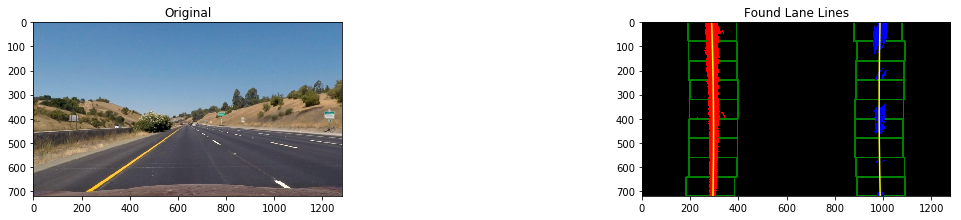

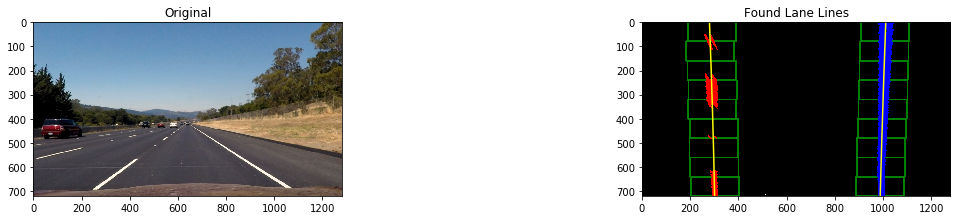

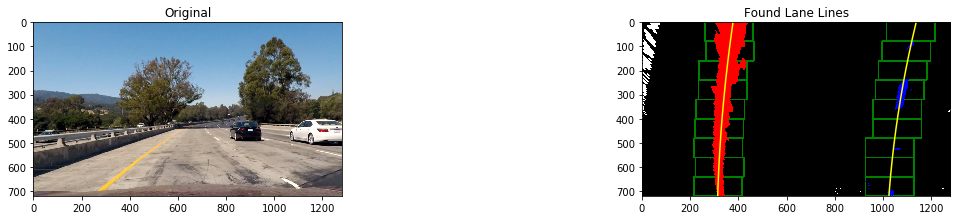

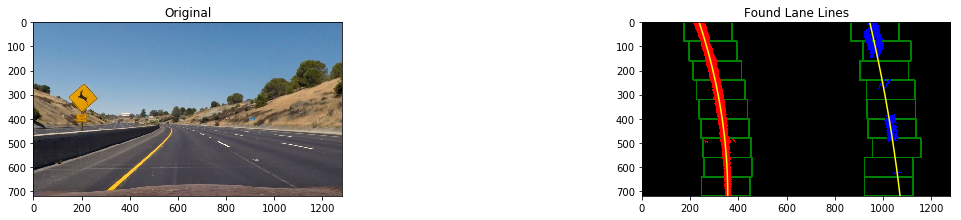

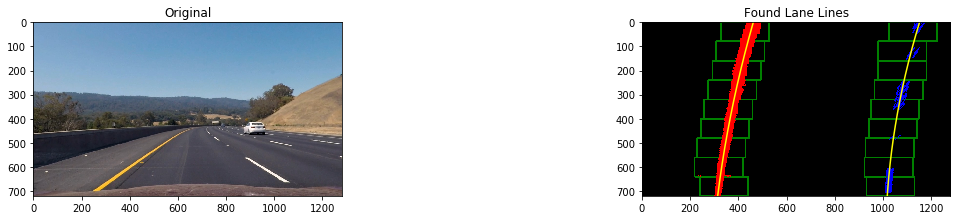

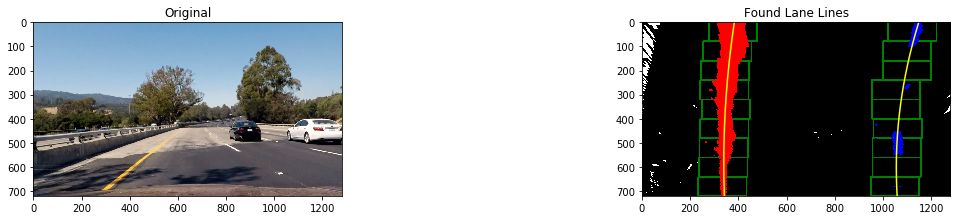

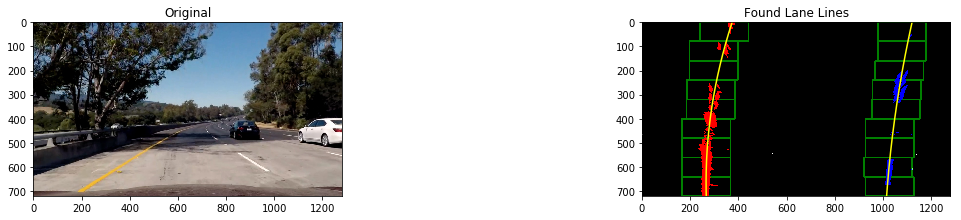

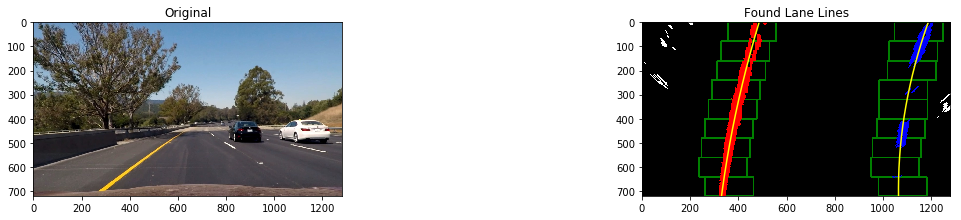

In [59]:
def showLaneLines():
    """
    
    This function loads the test images, performs the processImages function on the image and displays the
    output
    
    Args: None
    Returns: None
    
    """
    for i in range(8):
        left.__init__()
        right.__init__()
        
        #Load the images
        path = TESTIMAGES[i]
        img = mpimg.imread(path)
        
        # Process the images
        img, result, left_fitx, right_fitx, ploty = processImage(img, filetype='image')
        
        # Display the images
        plt.figure(figsize=(20,30))
        plt.subplot(8,2,2*i+1)
        plt.imshow(img)
        plt.title('Original')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.subplot(8,2,2*i+2)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.title('Found Lane Lines')
        left.detected = False
        right.detected = False
    plt.show()
    
if __name__=="__main__":
    showLaneLines()
        

In [60]:
def videoOutput():
    """
    
    This function loads a test video, performs the processImage() function on each video frame and writes the
    output video
    
    Args: None
    Return: None
    
    """
    left = Line()
    right = Line()
    left.__init__()
    right.__init__()
    video_output = 'project_video_subclip.mp4'
    clip1 = VideoFileClip("project_video.mp4").subclip(0,5) # Load a 5 second subclip
    #clip1 = VideoFileClip("project_video.mp4")
    white_clip = clip1.fl_image(processImage) # Perform the process image function
    white_clip.write_videofile(video_output, audio=False) # Write the output video
    
if __name__=="__main__":
    videoOutput()

[MoviePy] >>>> Building video project_video_subclip.mp4
[MoviePy] Writing video project_video_subclip.mp4


 99%|█████████▉| 125/126 [00:21<00:00,  5.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_subclip.mp4 



In [61]:
# Display the processed image
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('project_video_subclip.mp4'))